## AlexNet from scratch

AlexNet is an deep CNN achitecture from 2012. It has 8 capas
5 convolutional and 3 fully connected and 3 pooling.
<img src="AlexNetArch.png" width="776.8" height="376.8" />

1. Conv1: 96 filtros de 11×11, stride 4, activación ReLU <-> Conv1: 96 filtros de 5x5, stride 1, activación ReLU
2. MaxPooling1: 3×3, stride 2
3. Conv2: 256 filtros de 5×5, activación ReLU
4. MaxPooling2: 3×3, stride 2
5. Conv3: 384 filtros de 3×3, activación ReLU
6. Conv4: 384 filtros de 3×3, activación ReLU
7. Conv5: 256 filtros de 3×3, activación ReLU
8. MaxPooling3: 3×3, stride 2
9. FC1: 4096 neuronas, activación ReLU, dropout
10. FC2: 4096 neuronas, activación ReLU, dropout
11. FC3: 1000 neuronas (salida para clasificación en 1000 clases de ImageNet)

Análisis del tamaño de la salida de las capas convolucionales:
Dado que las imágenes se redimensionaron a 64x64
Después de todas las capas de convolución y pooling, la salida tiene 256 canales y un tamaño espacial de 7x7. Así que, el número de elementos en la salida será:
256×7×7=12544

El tamaño de la entrada para la capa Linear debe ser 12544

## Pytorch

In [1]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm import tqdm  # For progress bar

torch.cuda.is_available()

True

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(AlexNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 4096),  # ajustado para imágenes de 64x64
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


El Instituto Canadiense de Investigación Avanzada (CIFAR, por sus siglas en inglés) desarrolló un conjunto de datos estándar de visión artificial y Deep Learning para este problema.

El conjunto de datos CIFAR-10 consta de 60.000 fotos divididas en 10 clases:
1. airplane 										
2. automobile 										
3. bird 										
4. cat 										
5. deer 										
6. dog 										
7. frog 										
8. horse 										
9. ship 										
10. truck

El conjunto de datos se divide en 50.000 imágenes para train y 10.000 para test. Las fotos son en color con canales RGB, por lo que tienen un tamaño de $32 × 32 × 3$ píxeles.
Se realizo un "resize" a 64X64 ya que las imagenes son mas pequeñas que las de ImageNet para el cual fue creado originalmente AlexNet y también considerando la capacidad de mi GPU
Nvidia 1050 Ti.
| **Nvidia 1050 Ti.**         | **Valores**       |
|----------------------------|-----------------|
| **CUDA Cores**              | 768             |
| **Frame Buffer**            | 4 GB GDDR5      |
| **Velocidad de Memoria**    | 7 Gbps          |
| **Boost Clock**             | 1392 MHz        |


In [ ]:
#Cargar datos de CIFAR-10 para el reconocimiento de objetos.
# Code for Data Loading and Augmentation
batch_size = 64
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.Resize((64, 64)), 
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize                                
                                ]) # # Resize images to 227x227 and Convert images to PyTorch tensors

trainset = CIFAR10(root='./CIFAR10_data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = CIFAR10(root='./CIFAR10_data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


In [4]:
import torch.optim as optim

# Inicializar modelo, optimizador y función de pérdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet().to(device)

criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005, nesterov=True) 

print(device)

cuda


In [5]:
import time
start_time = time.time()
epochs = 20
# Entrenar modelo desde cero
for epoch in range(epochs):  # Entrenar 25 épocas
    running_loss = 0.0
    model.train()
    for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Accumulate loss

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluate the model on the test set after each epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")
# Medir tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time
execution_time /= 60  # Convertir a minutos
print(f"Tiempo de ejecución de la celda anterior: {execution_time:.2f} minutos")

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s]


Epoch 1, Loss: 1.0143
Test Accuracy after Epoch 1: 50.39%


Epoch 2: 100%|██████████| 782/782 [03:59<00:00,  3.27it/s]


Epoch 2, Loss: 0.9046
Test Accuracy after Epoch 2: 67.25%


Epoch 3: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]


Epoch 3, Loss: 1.0421
Test Accuracy after Epoch 3: 72.72%


Epoch 4: 100%|██████████| 782/782 [03:50<00:00,  3.39it/s]


Epoch 4, Loss: 1.0722
Test Accuracy after Epoch 4: 74.62%


Epoch 5: 100%|██████████| 782/782 [03:57<00:00,  3.30it/s]


Epoch 5, Loss: 0.8072
Test Accuracy after Epoch 5: 76.63%


Epoch 6: 100%|██████████| 782/782 [03:59<00:00,  3.27it/s]


Epoch 6, Loss: 0.1926
Test Accuracy after Epoch 6: 79.29%


Epoch 7: 100%|██████████| 782/782 [03:59<00:00,  3.26it/s]


Epoch 7, Loss: 0.6381
Test Accuracy after Epoch 7: 81.31%


Epoch 8: 100%|██████████| 782/782 [04:01<00:00,  3.24it/s]


Epoch 8, Loss: 0.3782
Test Accuracy after Epoch 8: 83.04%


Epoch 9: 100%|██████████| 782/782 [04:00<00:00,  3.26it/s]


Epoch 9, Loss: 0.4416
Test Accuracy after Epoch 9: 82.22%


Epoch 10: 100%|██████████| 782/782 [03:59<00:00,  3.26it/s]


Epoch 10, Loss: 0.5217
Test Accuracy after Epoch 10: 80.24%


Epoch 11: 100%|██████████| 782/782 [04:00<00:00,  3.25it/s]


Epoch 11, Loss: 0.2653
Test Accuracy after Epoch 11: 83.91%


Epoch 12: 100%|██████████| 782/782 [03:59<00:00,  3.27it/s]


Epoch 12, Loss: 0.4890
Test Accuracy after Epoch 12: 84.96%


Epoch 13: 100%|██████████| 782/782 [04:00<00:00,  3.26it/s]


Epoch 13, Loss: 0.3092
Test Accuracy after Epoch 13: 84.49%


Epoch 14: 100%|██████████| 782/782 [03:59<00:00,  3.26it/s]


Epoch 14, Loss: 0.0887
Test Accuracy after Epoch 14: 85.38%


Epoch 15: 100%|██████████| 782/782 [03:59<00:00,  3.27it/s]


Epoch 15, Loss: 0.3258
Test Accuracy after Epoch 15: 83.55%


Epoch 16: 100%|██████████| 782/782 [03:58<00:00,  3.27it/s]


Epoch 16, Loss: 0.2789
Test Accuracy after Epoch 16: 86.15%


Epoch 17: 100%|██████████| 782/782 [03:59<00:00,  3.27it/s]


Epoch 17, Loss: 0.1584
Test Accuracy after Epoch 17: 85.39%


Epoch 18: 100%|██████████| 782/782 [03:59<00:00,  3.26it/s]


Epoch 18, Loss: 0.1027
Test Accuracy after Epoch 18: 85.73%


Epoch 19: 100%|██████████| 782/782 [03:59<00:00,  3.27it/s]


Epoch 19, Loss: 0.2510
Test Accuracy after Epoch 19: 86.79%


Epoch 20: 100%|██████████| 782/782 [04:00<00:00,  3.26it/s]


Epoch 20, Loss: 0.2800
Test Accuracy after Epoch 20: 86.87%
Tiempo de ejecución de la celda anterior: 84.41 minutos


In [7]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
count_params( model ) 

AlexNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_

71926858

In [9]:
# Get general purpose APIs first
import numpy as np
import matplotlib.pyplot as plt

# load the Pytorch APIs
import torchvision

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 8. Class-wise accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f} %')

Accuracy of plane : 91.07 %
Accuracy of car   : 90.00 %
Accuracy of bird  : 77.22 %
Accuracy of cat   : 78.08 %
Accuracy of deer  : 80.00 %
Accuracy of dog   : 83.05 %
Accuracy of frog  : 85.71 %
Accuracy of horse : 85.94 %
Accuracy of ship  : 93.10 %
Accuracy of truck : 94.87 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


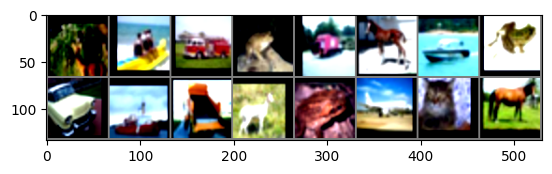

 deer || ship || truck || frog || truck || horse || ship || frog || car || ship || truck || deer || frog || plane || cat || horse


In [11]:
def imageshow(image):
   # un-normalize the image
   image = image/2 + 0.5
   npimage = image.numpy()
   plt.imshow(np.transpose(npimage, (1, 2, 0)))
   plt.show()

# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)
# display images in a grid
num_images = 16
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print(' ' + ' || '.join(classes[labels[j]]
        for j in range(num_images)))



In [12]:
# Save the trained model weights, checkpoint
# Guardar el checkpoint completo
checkpoint = {
    'epoch': epoch + 1,  # Número de la época actual
    'model_state_dict': model.state_dict(),  # Pesos del modelo
    'optimizer_state_dict': optimizer.state_dict(),  # Estado del optimizador
    'loss': running_loss  # (Opcional) Última pérdida
}

# Guardar el checkpoint en un archivo
torch.save(checkpoint, 'alexnet_cifar10_pt.pth')

#torch.save(model.state_dict(), "alexnet_cifar10.pth")
